<a href="https://colab.research.google.com/github/weathon/3d2smile/blob/main/with_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libs

In [48]:
import torch
import os
import numpy as np
import pylab
import pandas
import sys
from PIL import Image

In [ ]:
!git clone https://github.com/sergsb/IUPAC2Struct.git

In [10]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  if not "80k" in "".join(os.listdir("/content")):
    HOME_DIR = "/content"
else:
  if not "80k" in "".join(os.listdir("/arc/project/st-dushan20-1/rendered")):
    HOME_DIR = "/arc/project/st-dushan20-1/rendered"

In [15]:
sys.path.append(f"{HOME_DIR}/IUPAC2Struct")

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
M = torch.load(f"{HOME_DIR}/IUPAC2Struct/models/iupac2smiles_model.pt", map_location=device)

In [22]:
M.tgt_model.encode("CC(=O)Nc1ccc(O)cc1")

[27, 27, 8, 23, 38, 9, 37, 54, 14, 54, 54, 54, 8, 38, 9, 54, 54, 14]

In [24]:
smiles_tokenlizer = M.tgt_model.encode

In [ ]:
M.

# Data Processing

In [6]:

if IN_COLAB:
  if not "80k" in "".join(os.listdir("/content")):
    os.system("cp drive/MyDrive/80k.zip .")
    os.system("cp drive/MyDrive/80k.csv .")
    os.system("unzip 80k.zip")
    HOME_DIR = "/content"
else:
  if not "80k" in "".join(os.listdir("/arc/project/st-dushan20-1/rendered")):
    os.system("wget file.weasoft.com/80k.zip")
    os.system("wget http://file.weasoft.com/80k.csv")
    os.system("unzip 80k.zip")
    HOME_DIR = "/arc/project/st-dushan20-1/rendered"


Index(['cid', 'cmpdname', 'cmpdsynonym', 'mw', 'mf', 'polararea', 'complexity',
       'xlogp', 'heavycnt', 'hbonddonor', 'hbondacc', 'rotbonds', 'inchi',
       'isosmiles', 'canonicalsmiles', 'inchikey', 'iupacname', 'exactmass',
       'monoisotopicmass', 'charge', 'covalentunitcnt', 'isotopeatomcnt',
       'totalatomstereocnt', 'definedatomstereocnt', 'undefinedatomstereocnt',
       'totalbondstereocnt', 'definedbondstereocnt', 'undefinedbondstereocnt',
       'pclidcnt', 'gpidcnt', 'gpfamilycnt', 'neighbortype', 'meshheadings',
       'annothits', 'annothitcnt', 'aids', 'cidcdate', 'sidsrcname', 'depcatg',
       'annotation'],
      dtype='object')

In [35]:
import os
ids = [i.split("_")[0] for i in os.listdir(f"{HOME_DIR}/rendered")]

with open("ids.txt", "w") as f:
    f.write("\n".join(list(set(ids))))

import pandas as pd
csv = pd.read_csv("80k.csv")
cids = csv["cid"]
csv.columns

Index(['cid', 'cmpdname', 'cmpdsynonym', 'mw', 'mf', 'polararea', 'complexity',
       'xlogp', 'heavycnt', 'hbonddonor', 'hbondacc', 'rotbonds', 'inchi',
       'isosmiles', 'canonicalsmiles', 'inchikey', 'iupacname', 'exactmass',
       'monoisotopicmass', 'charge', 'covalentunitcnt', 'isotopeatomcnt',
       'totalatomstereocnt', 'definedatomstereocnt', 'undefinedatomstereocnt',
       'totalbondstereocnt', 'definedbondstereocnt', 'undefinedbondstereocnt',
       'pclidcnt', 'gpidcnt', 'gpfamilycnt', 'neighbortype', 'meshheadings',
       'annothits', 'annothitcnt', 'aids', 'cidcdate', 'sidsrcname', 'depcatg',
       'annotation'],
      dtype='object')

In [36]:
Ys = {}
invalid_cids = []
for i in cids.values:
  try:
    tmp = smiles_tokenlizer(csv[csv["cid"] == i]["canonicalsmiles"].values[0])
    if not tmp == None:
      Ys[i] = tmp
    else:
      smiles_tokenlizer.append(i)

  except:
    invalid_cids.append(i)

In [37]:
if len(invalid_cids) == 0:
  print("OOHH")

OOHH


In [55]:
example_in = Image.open(f"{HOME_DIR}/rendered/6912034_0.jpg")
example_out = csv[csv["cid"]==6912034]["canonicalsmiles"].values[0]

In [56]:
example_out

'CC(=O)C'

In [38]:
M.tgt_model.decode(Ys[6912034])

'CC(=O)C'

# Model


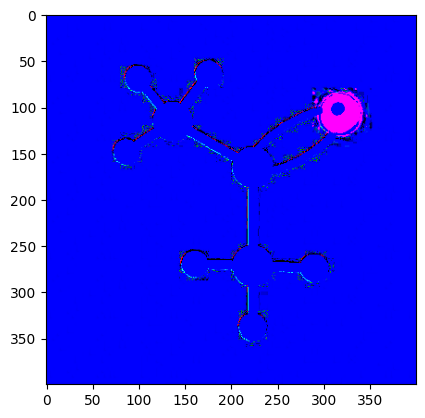

In [307]:
class ResNetBlock(torch.nn.Module):
  def __init__(self, in_channels, out_channels, size, downsampling=True):
    super().__init__()
    self.Conv2D = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, (3,3), stride=2 if downsampling else 1, padding=(3 if size%2==0 else 2) if downsampling else 2),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(),
        torch.nn.Conv2d(out_channels, out_channels, (3,3)),
        torch.nn.BatchNorm2d(out_channels),
    )
    self.project = torch.nn.Conv2d(in_channels, out_channels, (1,1))
    self.pooling = torch.nn.AvgPool2d((2,2)) if downsampling else torch.nn.Identity()
    self.relu = torch.nn.ReLU()

  def forward(self, images):
    x = self.Conv2D(images)
    images = self.pooling(self.project(images))
    return self.relu(x+images)
resblock = ResNetBlock(3,12,400, 0)
inp = torch.permute(torch.tensor(np.expand_dims(example_in, 0).astype("float32")), (0,3,1,2))
oup = resblock(inp)[:,-3:,:,:]
pylab.imshow(torch.permute(oup, (0,2,3,1)).detach().numpy()[0])

In [107]:
torch.permute(torch.tensor(np.expand_dims(example_in, 0).astype("float32")), (0,3,1,2)).size()

torch.Size([1, 3, 400, 400])

In [201]:
t = torch.randn(1,64,400,400)
torch.flatten(t)
torch.flatten(t, start_dim=2,end_dim=3).shape

torch.Size([1, 64, 160000])

In [353]:
class ImageEncoder(torch.nn.Module):
  def __init__(self, channels_list, heads, dropout, orginal_size):
    super().__init__()
    self.conv2d = torch.nn.Sequential(
        # torch.nn.Conv2d(3, 32, (7, 7), stride=3),
        # torch.nn.AvgPool2d((3,3), padding=1)
        torch.nn.Conv2d(3, 32, (7, 7), stride=2, padding=1),
        torch.nn.MaxPool2d((3, 3), stride=2)
    )
    self.resnet_blocks = []
    for i in range(len(channels_list)-1):
      self.resnet_blocks.append(ResNetBlock(channels_list[i], channels_list[i], size=66//(2**i)))
      self.resnet_blocks.append(ResNetBlock(channels_list[i], channels_list[i+1], size=66//(2**i), downsampling=False)) #gangcai self not defined

    self.mha = torch.nn.MultiheadAttention(channels_list[-1], heads, dropout = 0.1)

  def forward(self, images):
    features = self.conv2d(images)
    for f in self.resnet_blocks:
      features = f(features)
    features = torch.flatten(features, start_dim=2, end_dim=3)
    features = torch.permute(features, (0, 2, 1))
    att =  self.mha(features, features, features, need_weights=False)[0]
    features = att + features
    return features


In [ ]:
out = M.T.decoder(M.T.tgt_embedder(tgt), latent, src_mask, subsequent_mask((tgt != 0).unsqueeze(-2)))

In [354]:
NUM_HEADS = 8
CHANNELS = [32, 64, 128, 256, 512]
DROPOUT = 0.1

encoder = ImageEncoder(CHANNELS, NUM_HEADS, DROPOUT, 400)
encoder(inp).shape

torch.Size([1, 36, 512])